# Fit AdapIF to HH Spike Trains

In [1]:
from brian2 import *
from brian2modelfitting import *

import numpy as np

WARNING    /home/alteska/anaconda3/envs/brian_opt/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)
 [py.warnings]
WARNING    /home/alteska/anaconda3/envs/brian_opt/lib/python3.7/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)
 [py.warnings]


In [2]:
dt = 0.01*ms
defaultclock.dt = dt

## Load the Data

In [3]:
voltage1 = genfromtxt('voltage1nA.csv', delimiter=',')
voltage2 = genfromtxt('voltage2nA.csv', delimiter=',')

In [4]:
inp_cur1 = genfromtxt('inp_cur1nA.csv', delimiter=',')
inp_cur2 = genfromtxt('inp_cur2nA.csv', delimiter=',')
inp_current = [inp_cur1, inp_cur2]
inp_current

[array([ 0.        , -0.01416314,  0.06263459, ..., -0.44478035,
        -0.39163954, -0.33014548]),
 array([ 0.        ,  0.39594954,  0.27878635, ..., -0.55344109,
        -0.71057181, -0.62256885])]

In [5]:
out_spikes1 = genfromtxt('out_spikes1nA.csv', delimiter=',')
out_spikes2 = genfromtxt('out_spikes2nA.csv', delimiter=',')
out_spikes = [out_spikes1, out_spikes2]
# out_spikes

## Model Fitting

In [6]:
# tau = 12.44*ms
# taut = 97.64*ms
# a = 0.21
# alpha = 7.2*mV
# R = 76*Mohm

model = '''
        dv/dt = (R*I- v)/tau : 1
        dvt/dt = (a*v - vt) / taut :1
        alpha : 1 (constant)
        a : 1 (constant)
        R : 1/amp (constant)
        tau : second (constant)
        taut : second (constant)
        '''

reset = '''
v = 0
vt = vt + alpha
'''

In [7]:
set_device('cpp_standalone', directory='parallel2', clean=False)

In [8]:
n_opt = NevergradOptimizer('DE')
metric = GammaFactor(time=50*second, delta=4*ms)

In [9]:
fitter = SpikeFitter(model=model, input_var='I', dt=dt,
                     input=inp_current * nA, output=out_spikes,
                     n_samples=100,
                     threshold='v > 1 + vt',
                     reset=reset,
                     refractory=2*ms,
                     )

exponential_euler


In [10]:
result_dict, error = fitter.fit(n_rounds=30,
                                optimizer=n_opt,
                                metric=metric,
                                callback='text',
                                alpha=[0.1, 2.2],
                                a = [0.01, 0.1],
                                R = [1, 15] * 1/nA, 
                                tau = [7, 15]*ms,
                                taut = [30, 100]*ms,
                               )

Round 0: fit (8727946821.230711, 0.024446392269711542, 0.6730804968646955, 0.07006168106216007, 0.012048738546221734) with error: 0.04095559196560693
Round 1: fit (10146166351.097477, 0.08332502772077789, 1.013471835556361, 0.0477022764093397, 0.013738088667130739) with error: 0.03941906930830366
Round 2: fit (11676026187.227045, 0.03319922183953772, 0.6805672156222986, 0.08856609254409092, 0.013713708555831157) with error: 0.02485006139899848
Round 3: fit (10638893349.994156, 0.0675033314613198, 0.7142607194616257, 0.0792808392011894, 0.013255268121003874) with error: 0.0010654323772445462
Round 4: fit (10638893349.994156, 0.0675033314613198, 0.7142607194616257, 0.0792808392011894, 0.013255268121003874) with error: 0.0010654323772445462
Round 5: fit (10638893349.994156, 0.0675033314613198, 0.7142607194616257, 0.0792808392011894, 0.013255268121003874) with error: 0.0010654323772445462
Round 6: fit (10638893349.994156, 0.0675033314613198, 0.7142607194616257, 0.0792808392011894, 0.013255

In [11]:
result_dict

{'R': 10844772693.230858,
 'a': 0.017599819947209286,
 'alpha': 0.7934076487945085,
 'taut': 0.06804800236847092,
 'tau': 0.013758977268722508}

In [12]:
print('a', result_dict['a'])
print('tau', in_unit(result_dict['tau']*second, ms))
print('R', result_dict['R'])
print('taut', in_unit(result_dict['taut']*second, ms))
print('alpha', result_dict['alpha'])

a 0.017599819947209286
tau 13.75897727 ms
R 10844772693.230858
taut 68.04800237 ms
alpha 0.7934076487945085


In [13]:
error

0.0010654323772445462

In [14]:
1 - error

0.9989345676227555

In [15]:
device.reinit()
device.activate()

In [16]:
# visualization of the results
spikes = fitter.generate_spikes(params=None)
# print('spike times:', spikes)

exponential_euler


In [17]:
print(len(out_spikes[0]))
print(len(spikes[0]))

918
1063


In [18]:
print(len(out_spikes[1]))
print(len(spikes[1]))

1505
0


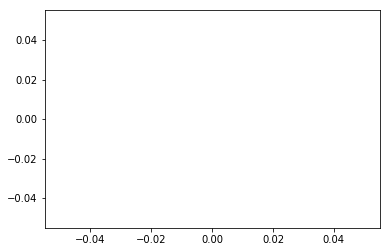

In [39]:
scatter(spikes[1], np.ones_like(spikes[1]));

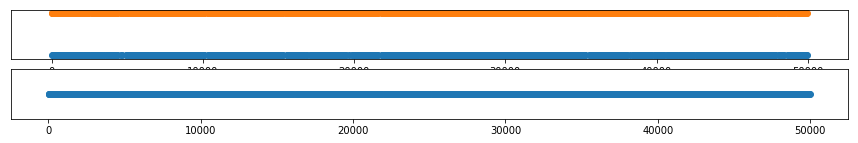

In [19]:
d=-1

fig, ax = plt.subplots(nrows=2, figsize=(15,2))

ax[0].set_yticks(np.arange(0, 1, step=1))
ax[0].scatter(out_spikes[0][:d], np.ones_like(out_spikes[0][:d]));
ax[0].scatter(spikes[0][:d], np.ones_like(spikes[0][:d])*2);

ax[1].set_yticks(np.arange(0, 1, step=1))
ax[1].scatter(out_spikes[1][:d], np.ones_like(out_spikes[1][:d]));
ax[1].scatter(spikes[1][:d], np.ones_like(spikes[1][:d])*2);

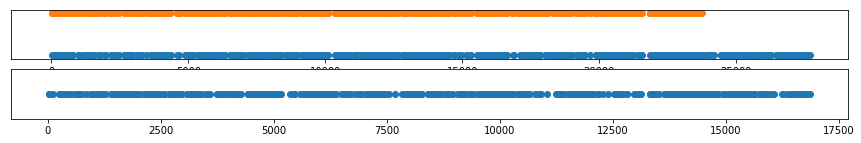

In [20]:
d=500


fig, ax = plt.subplots(nrows=2, figsize=(15,2))

ax[0].set_yticks(np.arange(0, 1, step=1))
ax[0].scatter(out_spikes[0][:d], np.ones_like(out_spikes[0][:d]));
ax[0].scatter(spikes[0][:d], np.ones_like(spikes[0][:d])*2);

ax[1].set_yticks(np.arange(0, 1, step=1))
ax[1].scatter(out_spikes[1][:d], np.ones_like(out_spikes[1][:d]));
ax[1].scatter(spikes[1][:d], np.ones_like(spikes[1][:d])*2);

In [21]:
device.reinit()
device.activate()

In [22]:
fits = fitter.generate(params=None, output_var='v',)

exponential_euler


In [23]:
t0 = np.arange(0, len(voltage1)*dt, dt)
t_ = spikes[0]
t = spikes[0][t_<3000]

In [24]:
t

array([   9.67,   11.67,   85.02,   90.7 ,  154.36,  177.01,  205.39,
        265.29,  290.06,  368.61,  411.21,  499.13,  506.32,  520.97,
        581.13,  590.25,  624.76,  686.7 ,  784.79,  853.54,  967.2 ,
        974.04, 1030.05, 1178.7 , 1184.86, 1202.77, 1276.95, 1313.59,
       1317.49, 1375.14, 1419.5 , 1422.14, 1464.  , 1513.24, 1516.2 ,
       1597.31, 1599.84, 1716.22, 1743.13, 1814.43, 1941.96, 1958.53,
       1984.9 , 2124.04, 2175.98, 2180.11, 2197.45, 2217.27, 2344.67,
       2417.21, 2421.42, 2426.73, 2434.52, 2648.15, 2684.49, 2728.9 ,
       2790.62, 2810.95, 2857.67, 2862.82, 2886.23, 2922.89, 2975.48,
       2986.6 ])

In [25]:
os = array(out_spikes[0])
os[os<3000]

array([  10.85,   86.77,  152.87,  177.99,  206.49,  255.46,  289.97,
        351.57,  372.45,  411.88,  501.64,  514.26,  569.2 ,  588.26,
        617.37,  659.91,  705.57,  796.7 ,  968.93, 1029.32, 1179.85,
       1201.26, 1277.75, 1314.76, 1374.47, 1408.51, 1422.03, 1462.08,
       1485.98, 1514.33, 1597.82, 1717.75, 1744.83, 1814.92, 1943.69,
       1985.12, 2178.47, 2198.5 , 2217.57, 2345.9 , 2418.41, 2427.14,
       2450.77, 2650.41, 2686.33, 2729.71, 2792.29, 2818.29, 2859.09,
       2884.83, 2922.46, 2975.51, 2988.59])

In [26]:
v = fits[0]
d = 300000

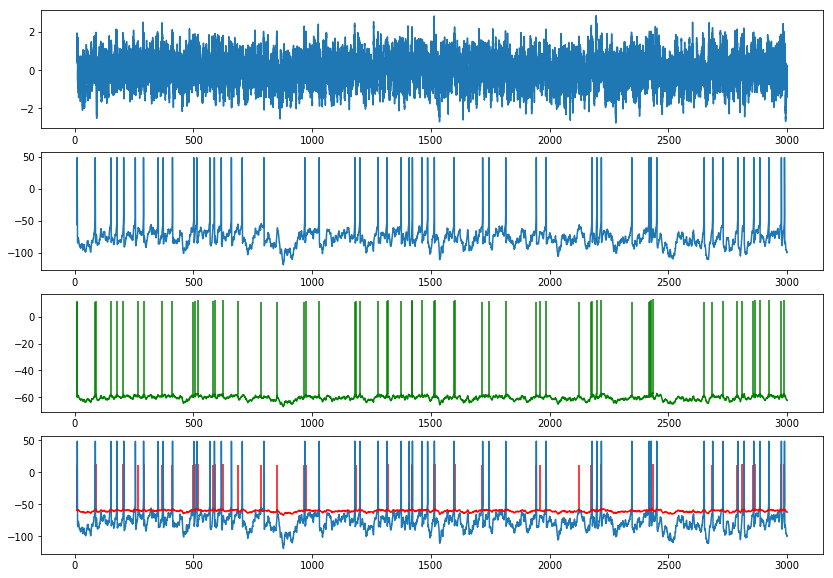

In [27]:
fig, ax = plt.subplots(nrows=4, figsize=(14,10))
ax[0].plot(t0[1000:d]/ms, inp_cur1[1000:d]);
ax[1].plot(t0[1000:d]/ms, voltage1[1000:d]);
ax[2].plot(t0[1000:d]/ms, v[1000:d]-60, 'g')
ax[2].vlines(t, v[np.int_(np.round(t/dt*ms))]+10, v[np.int_(np.round(t/dt*ms))]-60, 'g');

ax[3].plot(t0[1000:d]/ms, voltage1[1000:d]);
ax[3].plot(t0[1000:d]/ms, v[1000:d]-60, 'r')
ax[3].vlines(t, v[np.int_(np.round(t/dt*ms))]+10, v[np.int_(np.round(t/dt*ms))]-60, 'r');



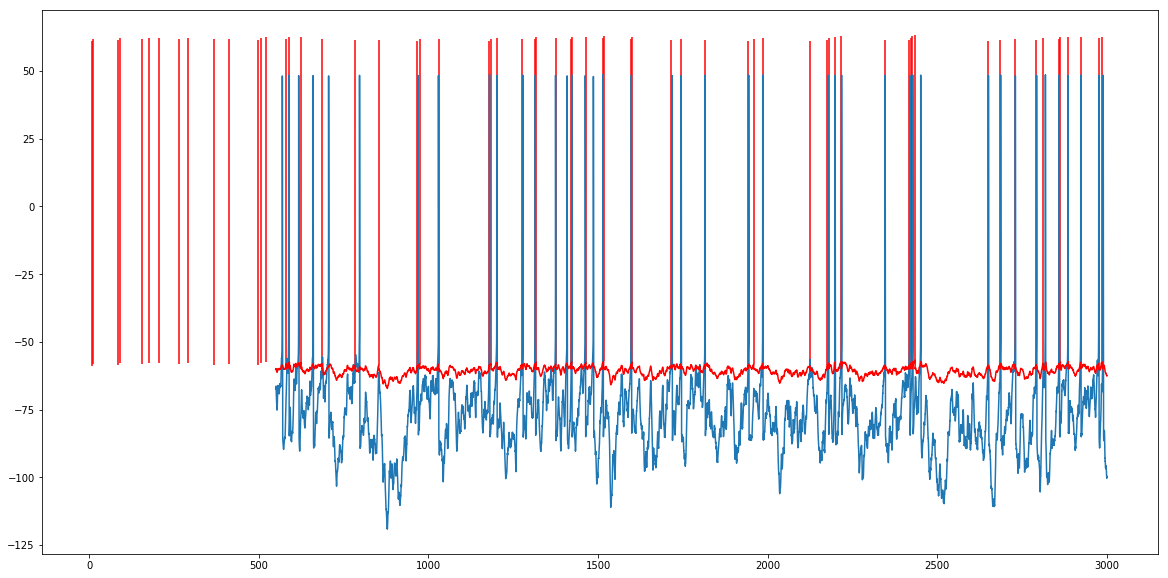

In [34]:
plt.figure(figsize=(20,10))
plot(t0[55000:d]/ms, voltage1[55000:d]);
plot(t0[55000:d]/ms, v[55000:d]-60, 'r')
vlines(t, v[np.int_(np.round(t/dt*ms))]+60, v[np.int_(np.round(t/dt*ms))]-60, 'r');
